In [10]:
pip install pyspark

  Using cached pyspark-3.5.3-py2.py3-none-any.whl
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: Python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
pip install pyspark-excel

ERROR: Could not find a version that satisfies the requirement pyspark-excel (from versions: none)
ERROR: No matching distribution found for pyspark-excel

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: Python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark

In [5]:
# spark = pyspark.sql.SparkSession.builder.appName("YourAppName").getOrCreate()

# df = spark.read.format("xlsx").option("header", True).load("data_MM.xlsx")
import pandas as pd

df = pd.read_excel("data_MM.xlsx")
df.head()

,Date,Brand Alias,Ad group alias,ASIN/SKU Alias,Marketplace,Impressions,Clicks,Spend,Sales,Orders,Units,Advertised Units sold,Other SKU units sold,Advertised SKU Sales,Other SKU sales
0,2021-10-17,Brand 1,Brand 1 Ad Group 10,ASIN414,Walmart,33,0,0.000,0.0,0,0,0,0,0.0,0.0
1,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN385,Walmart,0,0,0.000,0.0,0,0,0,0,0.0,0.0
2,2021-10-17,Brand 1,Brand 1 Ad Group 11,ASIN389,Walmart,0,0,0.000,0.0,0,0,0,0,0.0,0.0
3,2021-10-17,Brand 1,Brand 1 Ad Group 13,ASIN377,Walmart,380,8,2.340,0.0,0,0,0,0,0.0,0.0
4,2021-10-17,Brand 1,Brand 1 Ad Group 13,ASIN399,Walmart,3805,7,6.684,0.0,0,0,0,0,0.0,0.0


In [24]:
df.shape

(9586, 15)

In [68]:

# Pivot the DataFrame
df2 = df[['Marketplace','Clicks', 'Sales','Date','ASIN/SKU Alias']]
pivot_df = df2.pivot_table(index=['Date'], columns=['Marketplace'], values='Clicks')

df3 = df2.groupby('Date').sum('Sales')[['Sales']]

df4 = pivot_df.join(df3)


<Axes: >

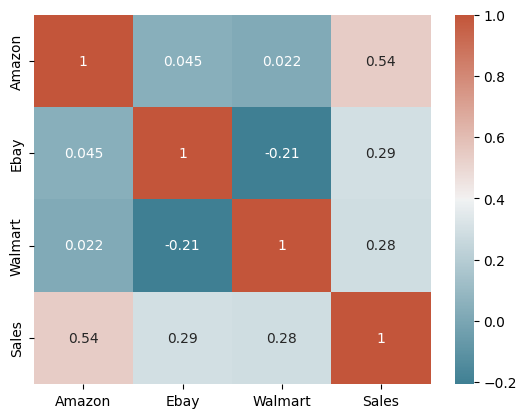

In [69]:
corr = df4.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True,cmap=sns.diverging_palette(220,20,as_cmap=True))

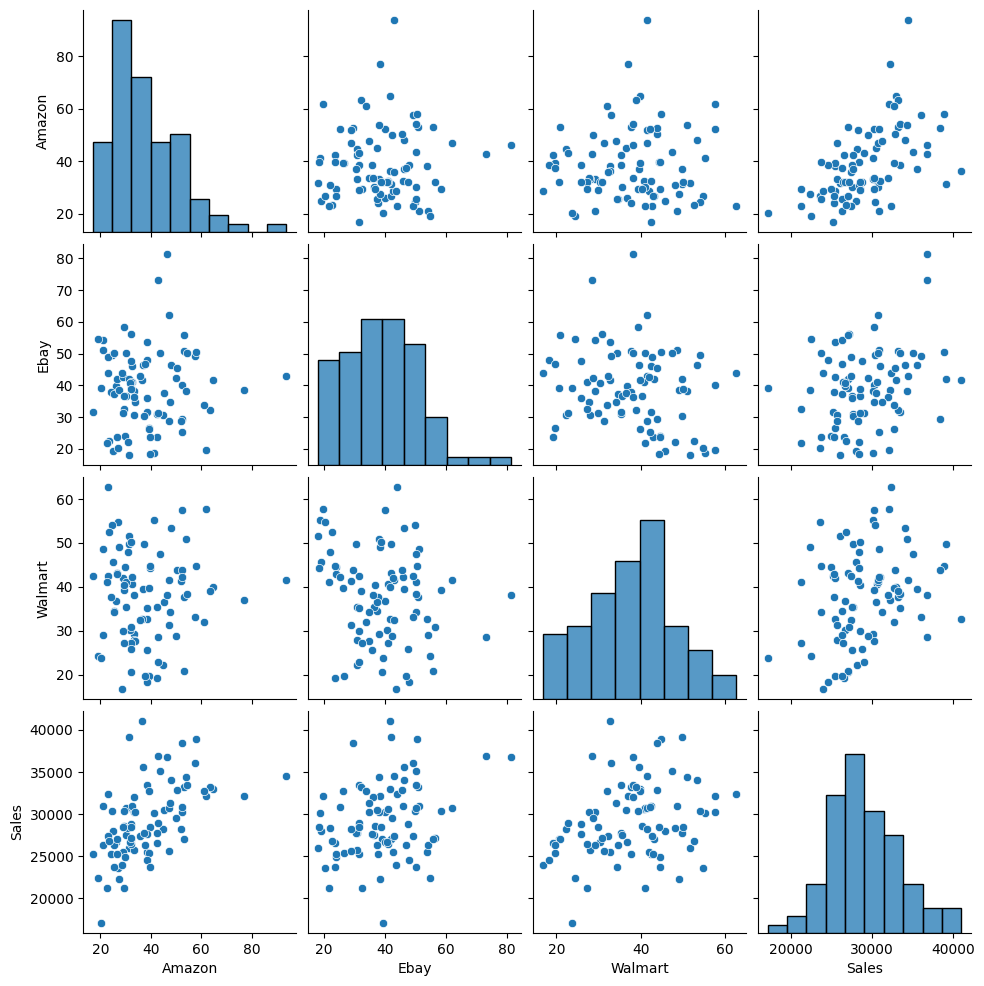

In [70]:
sns.pairplot(df4)

<Axes: >

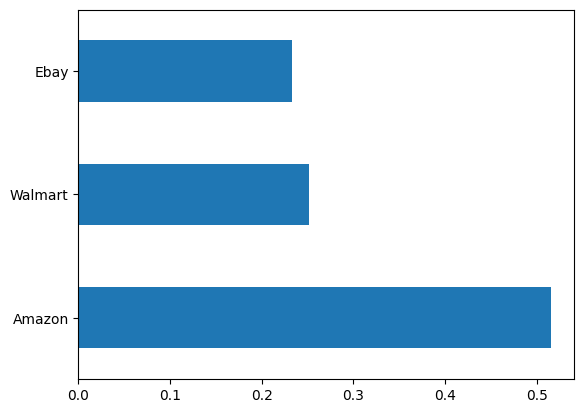

In [77]:
X = df4.loc[:,df4.columns!='Sales']
y = df4["Sales"]

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as mae
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, random_state=0)

model = RandomForestRegressor(random_state=1)
model.fit(X_train,y_train)
pred = model.predict(X_test)
feat_importances = pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [78]:
import statsmodels.formula.api as sm
model = sm.ols(formula="Sales~Amazon+Walmart+Ebay",data=df4).fit()

In [79]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     25.43
Date:                Tue, 08 Oct 2024   Prob (F-statistic):           9.13e-12
Time:                        23:08:13   Log-Likelihood:                -824.62
No. Observations:                  87   AIC:                             1657.
Df Residuals:                      83   BIC:                             1667.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.234e+04   2134.487      5.782      0.0

In [ ]:
Adj R squared means that46% of total variation in the data can be explained by the model.
generally want P value to be <1% or 5%

### F-statistic is 25.43. This is a relatively high value, suggesting that the overall model is statistically significant and that the independent variables (Amazon, Walmart, Ebay) collectively explain a significant portion of the variation in Sales.

 ### 47.9% of the variation in Sales is explained by the model, which suggests a moderately strong relationship.

 ### Prob (F-statistic): 9.13e-12 is a very small p-value, indicating that the overall regression model is highly statistically significant.

In [98]:

# Pivot the DataFrame
df2 = df[['Marketplace','Clicks', 'Sales','Date','ASIN/SKU Alias','Brand Alias','Spend']]
pivot_df = df2.pivot_table(index=['Date'], columns=['Marketplace','Brand Alias'], values='Spend')
# Add the marketplace suffix to the column names
pivot_df.columns = pivot_df.columns.map('_'.join).str.replace('Amazon', 'amazon_').str.replace('Ebay', 'ebay_').str.replace('Walmart', 'walmart_')

# Print the pivoted DataFrame
pivot_df


,amazon__Brand 1,amazon__Brand 2,ebay__Brand 1,ebay__Brand 2,walmart__Brand 1,walmart__Brand 2
Date,,,,,,
2021-10-17,17.750000,27.7575,21.674118,16.0920,5.133750,24.435000
2021-10-18,9.445294,29.4955,31.828235,28.2585,3.711000,38.514600
2021-10-19,25.347647,31.0020,40.268824,15.6390,43.641750,33.216600
2021-10-20,53.376471,20.5715,22.350000,19.8410,26.789250,49.585200
2021-10-21,155.310000,16.5880,24.658824,23.8000,7.145250,42.565800
...,...,...,...,...,...,...
2022-01-07,23.280000,35.8375,4.233529,27.9120,25.332706,31.025684
2022-01-08,27.647500,40.4565,11.774118,26.0420,19.296750,32.281200
2022-01-09,21.559375,24.2705,24.011176,38.8315,31.710000,28.393200


In [99]:

df3 = df2.groupby('Date').sum('Sales')[['Sales']]

df4 = pivot_df.join(df3)

<Axes: >

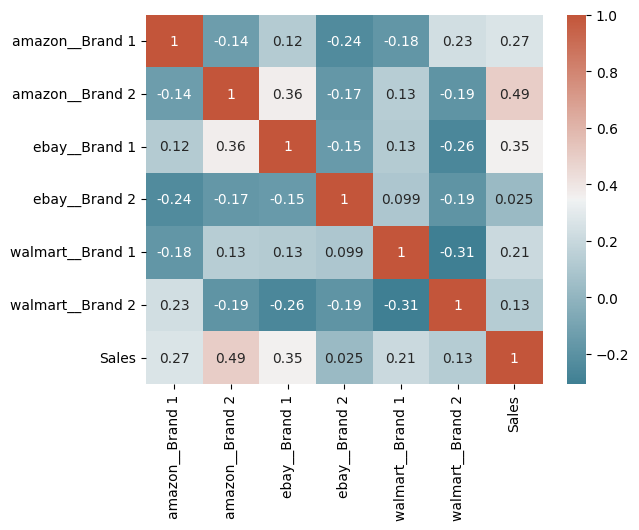

In [100]:
corr = df4.corr()
sns.heatmap(corr, xticklabels=corr.columns,yticklabels=corr.columns,annot=True,cmap=sns.diverging_palette(220,20,as_cmap=True))